In [1]:
from prettytable import PrettyTable
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg
import time
import operator
import chainer
import cupy as cp
chainer.print_runtime_info()

Platform: Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.5.0
ChainerX: Not Available
NumPy: 1.17.4
CuPy:
  CuPy Version          : 6.5.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10010
  cuDNN Build Version   : 7603
  cuDNN Version         : 7603
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: 2.0.0.post3


In [2]:
from google.colab import files
uploaded = files.upload()

Saving dtest123.dat.txt to dtest123.dat.txt
Saving dtrain123.dat.txt to dtrain123.dat.txt
Saving zipcombo.dat.txt to zipcombo.dat.txt


In [ ]:
mini_training_123 = np.loadtxt('dtest123.dat.txt')
mini_test_123 = np.loadtxt('dtrain123.dat.txt')
full_all_digits = np.loadtxt('zipcombo.dat.txt')

In [ ]:
mini_training_x = mini_training_123[:,  1:]
mini_training_y = mini_training_123[:,  0]

mini_test_x = mini_test_123[:, 1:]
mini_test_y = mini_test_123[:, 0]

full_digits_x = full_all_digits[:,1:]
full_digits_y = full_all_digits[:, 0]

In [ ]:
random_split = 0

full_digits_x = 0
full_digits_y = 0

random_split_x = 0
random_split_x = 0

train_data_x = 0
test_data_x = 0

train_data_y = 0
test_data_y = 0

random_split_train = 0
random_split_test = 0
runs = []


def randomize():
    """
    Shuffle the data set to separate train and test set
    """
    global random_split 
    global full_digits_x 
    global full_digits_y 
    global random_split_x 
    global random_split_y 
    global test_data_x
    global train_data_x
    global train_data_y
    global test_data_y
    global random_split_train
    global random_split_test

    random_split = full_all_digits.copy()
    np.random.shuffle(random_split)
    
    
    full_digits_x = random_split[:,1:]
    full_digits_y = random_split[:, 0]
    
    random_split_train = random_split[:7438, :]
    random_split_test = random_split[7438:,:]
    
    random_split_x = full_digits_x.copy()
    random_split_y = full_digits_y.copy()

    train_data_x = random_split_train[:,1:]
    test_data_x = random_split_test[:,1:]
    
    train_data_y = random_split_train[:,0]
    test_data_y = random_split_test[:,0]
    
randomize()

In [6]:
test_fold_1 = 0
test_fold_2 = 0
test_fold_3 = 0
test_fold_4 = 0
test_fold_5 = 0

training_fold_1 = 0
training_fold_2 = 0
training_fold_3 = 0
training_fold_4 = 0
training_fold_5 = 0

training_fold_x = 0
training_fold_y = 0

test_fold_x = 0
test_fold_y = 0
def randomize2():
    """
    Making a framework for 5-fold cross validation
    """
    global test_fold_1
    global test_fold_2
    global test_fold_3
    global test_fold_4
    global test_fold_5

    global training_fold_1
    global training_fold_2
    global training_fold_3
    global training_fold_4
    global training_fold_5

    global training_fold_x
    global training_fold_y

    global test_fold_x
    global test_fold_y
    

    np.random.shuffle(random_split_train)
    
    train_data = random_split_train
    
    test_fold_1 = train_data[0:1487,]
    test_fold_2 = train_data[1487:2975,]
    test_fold_3 = train_data[2975:4463,]
    test_fold_4 = train_data[4463:5951,]
    test_fold_5 = train_data[5951:7439,]

    training_fold_1 = np.delete(train_data, range(0,1487), 0)
    training_fold_2 = np.delete(train_data, range(1487,2975), 0)
    training_fold_3 = np.delete(train_data, range(2975,4463), 0)
    training_fold_4 = np.delete(train_data, range(4463,5951), 0)
    training_fold_5 = np.delete(train_data, range(5951,7439), 0)

    training_fold_x = [training_fold_1[:,1:], training_fold_2[:,1:], training_fold_3[:,1:], training_fold_4[:,1:], training_fold_5[:,1:]]
    training_fold_y = [training_fold_1[:,0].reshape(1,training_fold_1[:,0].size), training_fold_2[:,0].reshape(1,training_fold_2[:,0].size), training_fold_3[:,0].reshape(1,training_fold_3[:,0].size), training_fold_4[:,0].reshape(1,training_fold_4[:,0].size), training_fold_5[:,0].reshape(1,training_fold_5[:,0].size)]

    test_fold_x = [test_fold_1[:,1:], test_fold_2[:,1:], test_fold_3[:,1:], test_fold_4[:,1:], test_fold_5[:,1:]]
    test_fold_y = [test_fold_1[:,0].reshape(1,test_fold_1[:,0].size), test_fold_2[:,0].reshape(1,test_fold_2[:,0].size), test_fold_3[:,0].reshape(1,test_fold_3[:,0].size), test_fold_4[:,0].reshape(1,test_fold_4[:,0].size), test_fold_5[:,0].reshape(1,test_fold_5[:,0].size)]

randomize2()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [ ]:
def kernel(x, x_prime, d):
    """
    Calculate kernel matrix
    :param x:          x_i, where i=1, ..., t-1
    :param x_prime:    x_t
    :param d:          A positive integer controlling the dimension of the polynomial
    """
    zero_mat = cp.matmul(x, x_prime)**d
    return zero_mat

def whatnumber(alpha, x_obs, x_cur, d):
    """
    Returning the most probable index, and corresponding probability vector
    :param alpha:      A parameter in our model that need to be learned
    :param x_obs:      x_i, where i=1, ..., t-1
    :param x_cur:      x_t
    :param d:          A positive integer controlling the dimension of the polynomial
    """
    prob_vec = cp.matmul(cp.transpose(alpha), kernel(x_obs, x_cur, d)).tolist()
    best = np.amax(prob_vec)
    return [np.array(prob_vec.index(best)), cp.array(prob_vec)]


def accuracy(alph, num_sam,  true_idx, test_x, x, d):
    """
    A function for calculate the validation error
    :param alpha:      A parameter in our model that need to be learned
    :param num_sam:    A length of the training set
    :param true_idx:   A true test y label
    :param test_x:     A test set (input)
    :param x:          A training set (input)
    :param d:          A positive integer controlling the dimension of the polynomial    
    """
    error = 0
    for i in range(num_sam):
        calc_whatnumber = whatnumber(alph, x, np.reshape(test_x[i,:], (len(test_x[i,:]),1)), d)
        most_prob_idx = calc_whatnumber[0]
        if int(true_idx[i]) != most_prob_idx:
            error+=1
    return error/num_sam


def online_learning_1(x, y, epochs, test_x, test_y, d):
    """
    Training the model 
    :param x:          A training set (input)
    :param true_idx:   A true training y label
    :param test_x:     A test set (input)
    :param test_y:     A true test y label
    :param d:          A positive integer controlling the dimension of the polynomial 
    Return:            Training accuracy, test accuracy, history of training accuracy, history of test accuracy,
                       best test accuracy, corresponding training accuracy, best alpha
    
    """ 
    alpha = cp.zeros((len(x[:,1])*epochs,10), dtype = "float32")
    store_train_acc = []
    store_test_acc = []
    store_alphas = []
    count = 0 
    acc = 0
    epoch = 0
    num_samp = len(x[:,1])
    x = cp.tile(x, (epochs, 1))
    y = cp.tile(y, (1, epochs))[0]
    test_x = cp.tile(test_x, (1,1))
    test_y = cp.tile(test_y, (1,1))[0]
    for t in range(1,num_samp*epochs):
        whatnumber_temp = whatnumber(alpha[:t,:], x[:t,:],cp.reshape(x[t,:], (len(x[t,:]),1)), d)
        most_prob_index = whatnumber_temp[0]
        prob_vecs = whatnumber_temp[1]            
        if most_prob_index != int(y[t]):
            real_y_idx = int(y[t])
            alpha[t,real_y_idx] += 1
            higher_pred_idx = cp.where(prob_vecs > prob_vecs[real_y_idx])[0]
            for i in higher_pred_idx:
                alpha[t,i] -= 1/len(higher_pred_idx)
            acc+=1
        if (t+1)%num_samp == 0:
            epoch += 1
            print("epoch:", epoch)
            print("training error:", acc/num_samp)
            test_acc = accuracy(alpha[:t,:], len(test_y), test_y, test_x, x[:t,:], d)
            print("test error:", test_acc)
            store_train_acc.append(acc/num_samp)
            store_test_acc.append(test_acc)
            store_alphas.append(alpha)
            # check if 3 consecutive training error is decreased considerably.
#            if epoch > 1:
#                if abs(store_train_acc[epoch-1] - store_train_acc[epoch-2]) < 0.0005:
#                    count +=1
#                    if count > 2:
#                        break
#                else:
#                    count = 0
            acc = 0
    best_test_acc = min(store_test_acc)
    best_test_acc_idx = store_test_acc.index(best_test_acc)
    corresponding_training_acc = store_train_acc[best_test_acc_idx]
    best_alpha = store_alphas[best_test_acc_idx][0:num_samp*epoch,:] # store alpha by slicing the indeces that we updated
    return [acc/num_samp, test_acc, store_train_acc, store_test_acc, best_test_acc, corresponding_training_acc, best_alpha, epoch]

In [10]:
test1 = online_learning_1(train_data_x, train_data_y, 50, test_data_x, test_data_y, 1)
print("______")
test2 = online_learning_1(train_data_x, train_data_y, 50, test_data_x, test_data_y, 2)
print("______")
test3 = online_learning_1(train_data_x, train_data_y, 50, test_data_x, test_data_y, 3)
print("______")
test4 = online_learning_1(train_data_x, train_data_y, 50, test_data_x, test_data_y, 4)
print("______")
test5 = online_learning_1(train_data_x, train_data_y, 50, test_data_x, test_data_y, 5)
print("______")
test6 = online_learning_1(train_data_x, train_data_y, 50, test_data_x, test_data_y, 6)
print("______")
test7 = online_learning_1(train_data_x, train_data_y, 50, test_data_x, test_data_y, 7)
print("______")

epoch: 1
training error: 0.13901586447969885
test error: 0.11720430107526882
epoch: 2
training error: 0.09007797795106211
test error: 0.10698924731182796
epoch: 3
training error: 0.0810701801559559
test error: 0.0967741935483871
epoch: 4
training error: 0.06991126646948104
test error: 0.1
epoch: 5
training error: 0.07192793761763915
test error: 0.08118279569892473
epoch: 6
training error: 0.06762570583490185
test error: 0.08602150537634409
epoch: 7
training error: 0.06829792955095455
test error: 0.1
epoch: 8
training error: 0.06171013713363808
test error: 0.09946236559139784
epoch: 9
training error: 0.06090346867437483
test error: 0.08763440860215053
epoch: 10
training error: 0.05888679752621673
test error: 0.1010752688172043
epoch: 11
training error: 0.05740790535090078
test error: 0.08548387096774193
epoch: 12
training error: 0.055391234202742674
test error: 0.07419354838709677
epoch: 13
training error: 0.05324011831137403
test error: 0.09247311827956989
epoch: 14
training error: 0.0

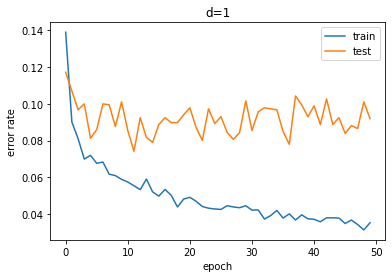

In [11]:
plt.plot(test1[2], label ='train')
plt.plot(test1[3], label = 'test')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.title('d=1')
plt.legend()
plt.show()

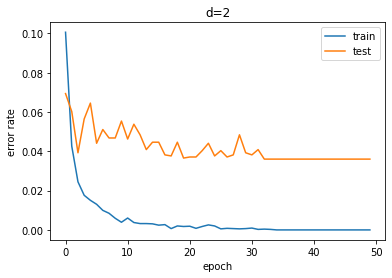

In [16]:
plt.plot(test2[2], label ='train')
plt.plot(test2[3], label = 'test')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.title('d=2')
plt.legend()
plt.show()

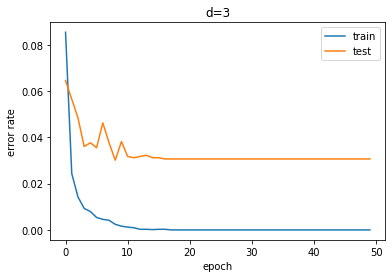

In [17]:
plt.plot(test3[2], label ='train')
plt.plot(test3[3], label = 'test')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.title('d=3')
plt.legend()
plt.show()

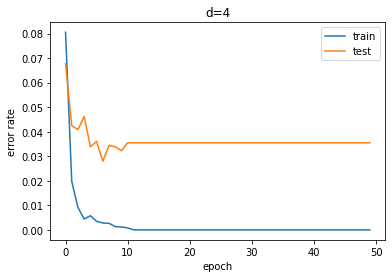

In [18]:
plt.plot(test4[2], label ='train')
plt.plot(test4[3], label = 'test')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.title('d=4')
plt.legend()
plt.show()

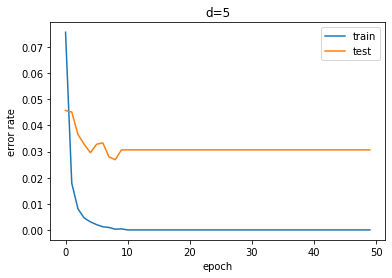

In [19]:
plt.plot(test5[2], label ='train')
plt.plot(test5[3], label = 'test')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.title('d=5')
plt.legend()
plt.show()

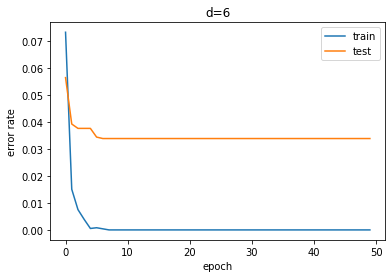

In [20]:
plt.plot(test6[2], label ='train')
plt.plot(test6[3], label = 'test')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.title('d=6')
plt.legend()
plt.show()

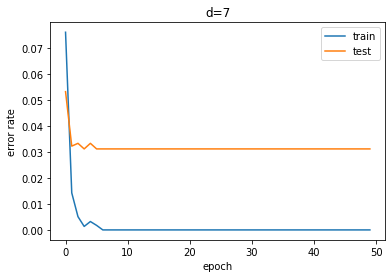

In [21]:
plt.plot(test7[2], label ='train')
plt.plot(test7[3], label = 'test')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.title('d=7')
plt.legend()
plt.show()